In [20]:
import csv
from sklearn import svm
import numpy as np
import pandas as pd
import Loader
import tensorflow as tf
import Transformer
import ModelFile
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn import model_selection
from sklearn.metrics import accuracy_score
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.losses import MeanSquaredError

compoundsTrain, smilesTrain, labelsTrain, compoundDataTrain, activitiesTrain = Loader.getTrain(defaultValue=0)
compoundsTest, smilesTest, labelsTest, compoundDataTest, activitiesTest = Loader.getTest(defaultValue=0)
compoundsValidate, smilesValidate, labelsValidate, compoundDataValidate, activitiesValidate = Loader.getValidate(defaultValue=0)

In [46]:

l1Reg = keras.regularizers.L1(.001)

optimizer = tf.keras.optimizers.Adam(
    learning_rate=0.001,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    amsgrad=False
)

"""
def runPCASVM(Xtrain, Ytrain, labelsTrain, compoundDataTest, compoundDataValidate):
    
    labelsPCA, trainPCA, testPCA, valPCA = Transformer.applyPCA(labelsTrain,  Xtrain, 
                                                        compoundDataTest, compoundDataValidate,
                                                        endDims=[1,1,9,4,6,7,3,16], muted = True)

    labelsMeanPCA, trainMeanPCA = Transformer.useAverageFD(labelsPCA, trainPCA)
    _, testMeanPCA = Transformer.useAverageFD(labelsPCA, testPCA)
    _, valMeanPCA = Transformer.useAverageFD(labelsPCA, valPCA)

    labelsMaxPCA, trainMaxPCA = Transformer.useMaxFD(labelsPCA, trainPCA)
    _, testMaxPCA = Transformer.useMaxFD(labelsPCA, testPCA)
    _, valMaxPCA = Transformer.useMaxFD(labelsPCA, valPCA)

    #after transformations are done assign data
    dataLabels = labelsMaxPCA
    trainData = trainMaxPCA
    testData = testMaxPCA
    valData = valMaxPCA

    Xtrain,_,valData = Transformer.normalizeData(trainData, testData, valData, newMean=0, newStd=1)
    
    
    maxC=10**-.01
    clf=svm.SVC(
        C=maxC,                          # The regularization parameter
        kernel='rbf',                   # The kernel type used 
        degree=4,                       # Degree of polynomial function 
        gamma='scale',                  # The kernel coefficient
        coef0=0.0,                      # If kernel = 'poly'/'sigmoid'
        shrinking=True,                 # To use shrinking heuristic
        probability=False,              # Enable probability estimates
        tol=0.001,                      # Stopping crierion
        cache_size=200,                 # Size of kernel cache
        class_weight=None,              # The weight of each class
        verbose=False,                  # Enable verbose output
        max_iter=- 1,                   # Hard limit on iterations
        decision_function_shape='ovr',  # One-vs-rest or one-vs-one
        break_ties=False,               # How to handle breaking ties
        random_state=None               # Random state of the model
    )
    clf.fit(Xtrain, Ytrain)
    predictions = clf.predict(Xtrain)
    val_pred = clf.predict(valData)
    return [predictions, val_pred]
    
"""
def runBasicSVM(Xtrain, Ytrain, compoundDataTest, compoundDataValidate, save, TSVM = False):
    maxC = 10

    clf=svm.SVC(
        C=maxC,                          # The regularization parameter (default 1)
        kernel='rbf',                   # The kernel type used (RBF: Gaussian Kernel Radial Basis Function)
        degree=1,                       # Degree of polynomial function (ONLY relevant for kernel="poly")
        gamma='scale',                  # The kernel coefficient
        coef0=0.0,                      # If kernel = 'poly'/'sigmoid'
        shrinking=True,                 # To use shrinking heuristic
        probability=False,              # Enable probability estimates
        tol=0.00001,                    # Stopping crierion
        cache_size=200,                 # Size of kernel cache
        class_weight=None,              # The weight of each class
        verbose=False,                  # Enable verbose output
        max_iter= -1,                   # Hard limit on iterations (-1 is no limit)
        decision_function_shape='ovr',  # One-vs-rest or one-vs-one (this don't matter)
        break_ties=False,               # How to handle breaking ties
        random_state=None               # Random state of the model
    )
    Xtrain,_,valData = Transformer.normalizeData(Xtrain, compoundDataTest, compoundDataValidate, newMean=0, newStd=1)
    clf.fit(Xtrain, Ytrain)
    predictions = clf.predict(Xtrain)
    val_pred = clf.predict(valData)
    
    if save:
        if TSVM:
            ModelFile.save(clf, "TSVM.pkl", "Tim's state of the art feature reduction SVM. This model was generated in the Full Model Testing file.")
        else:
            ModelFile.save(clf, "basicSVM.pkl", "Newest SVM without PCA. This model was generated in the Full Model Testing file.")

    
    return [predictions, val_pred]

def runTSVM(Xtrain, Ytrain, compoundDataTest, compoundDataValidate, dataLabels, save = True, TSVM = True):
    trainData = Xtrain
    classTrain = Ytrain
    valData = compoundDataValidate
    X_train, X_test, y_train, y_test = model_selection.train_test_split(trainData,classTrain,
                                       random_state=104, 
                                       test_size=0.20, 
                                       shuffle=True)
    col_idx = np.arange(0,210)
    probs = []
    for i in range(210):
        probs.append(float(50))
    probs = np.array(probs)
    eval_set = []

    for x in range(100):
        
        train_data_df = pd.DataFrame(X_train, columns = dataLabels)
        train_temp_df = train_data_df.copy()
        val_data_df = pd.DataFrame(X_test, columns = dataLabels)
        val_temp_df = val_data_df.copy()

        values = probs
        
        arr1 = values / values.min()
        arr1 = arr1 / arr1.sum()
        #print(arr1, arr1.sum())
        #display(values, sum(values))
        test_cols = np.random.choice(col_idx, 50, replace=False, p = arr1)
        # using set() to perform task
        test_cols_set = set(test_cols)
        col_idx_set = set(col_idx)
        zero_cols = list(col_idx_set - test_cols_set)
        
        train_temp_df.iloc[:, zero_cols] *= 0
        val_temp_df.iloc[:, zero_cols] *= 0
        
        
        Xtrain = train_temp_df.values
        Xval = val_temp_df.values
        accuracy = runBasicSVM(Xtrain, y_train, compoundDataTest, Xval , save, TSVM = True)
        curr_val_acc = accuracy_score(y_test, accuracy[1])
        
        if(x < 20):
            eval_set.append(curr_val_acc)
        else:
            
            if curr_val_acc > np.average(eval_set) + np.std(eval_set):
                np.multiply.at(probs,test_cols,1.1)
            elif curr_val_acc < np.average(eval_set) - np.std(eval_set):
                np.multiply.at(probs,test_cols,.9)
                prev_val_acc = accuracy[1]
            else:
                prev_val_acc = accuracy[1]
                
            eval_set.pop(0)
            eval_set.append(curr_val_acc)
        
            #print(probs)
    
    train_data_df = pd.DataFrame(trainData, columns = dataLabels)
    train_temp_df = train_data_df.copy()
    val_data_df = pd.DataFrame(valData, columns = dataLabels)
    val_temp_df = val_data_df.copy()
    
    top_50_idx = probs.argsort()[-50:]
    #test_cols = np.random.choice(col_idx, top_50_idx, replace=False, p = arr1)
    # using set() to perform task
    test_cols_set = set(top_50_idx)
    col_idx_set = set(col_idx)
    zero_cols = list(col_idx_set - test_cols_set)
    
    train_temp_df.iloc[:, zero_cols] *= 0
    val_temp_df.iloc[:, zero_cols] *= 0


    Xtrain = train_temp_df.values
    Xval = val_temp_df.values
    accuracy = runBasicSVM(Xtrain,classTrain, compoundDataTest, Xval, save, TSVM = True)

    return [accuracy[0], accuracy[1]]
"""
def runMinPCA(Xtrain,Ytrain, labelsTrain, compoundDataTest, compoundDataValidate, classVal):
    acc = 0
    labelsPCA, trainPCA, testPCA, valPCA = Transformer.applyPCA(labelsTrain,  Xtrain, 
                                                            compoundDataTest, compoundDataValidate,
                                                            endDims=[1,1,2,1,2,3,2,4], muted = True)

    labelsMeanPCA, trainMeanPCA = Transformer.useAverageFD(labelsPCA, trainPCA)
    _, testMeanPCA = Transformer.useAverageFD(labelsPCA, testPCA)
    _, valMeanPCA = Transformer.useAverageFD(labelsPCA, valPCA)

    labelsMaxPCA, trainMaxPCA = Transformer.useMaxFD(labelsPCA, trainPCA)
    _, testMaxPCA = Transformer.useMaxFD(labelsPCA, testPCA)
    _, valMaxPCA = Transformer.useMaxFD(labelsPCA, valPCA)

    #after transformations are done assign data
    dataLabels = labelsMaxPCA
    trainData = trainMaxPCA
    testData = testMaxPCA
    valData = valMaxPCA

    trainData,_,valData = Transformer.normalizeData(trainData, testData, valData, newMean=0, newStd=1)

    
        
    while(acc < .7):
        model = tf.keras.models.Sequential([
            tf.keras.layers.Dense(len(dataLabels), activation='relu', kernel_regularizer = l1Reg),
            tf.keras.layers.Dense(80, activation='relu', kernel_regularizer = l1Reg),
            tf.keras.layers.Dense(120, activation='relu', kernel_regularizer = l1Reg),
            tf.keras.layers.Dense(100, activation='relu', kernel_regularizer = l1Reg),
            tf.keras.layers.Dense(80, activation='relu', kernel_regularizer = l1Reg),
            tf.keras.layers.Dense(40, activation='relu', kernel_regularizer = l1Reg),
            tf.keras.layers.Dense(2, activation='relu', kernel_regularizer = l1Reg)
        ])

        model.compile(optimizer=optimizer,loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                   metrics=['accuracy'])
    
        history = model.fit(trainData, Ytrain, validation_data = (valData, classVal), epochs=100, batch_size=4, verbose = 0)
        predictionsTrain = np.argmax(model.predict(trainData), axis=1)
        predictionsTest = np.argmax(model.predict(valData), axis=1)
        acc = np.mean(predictionsTrain == Ytrain)
    return [ predictionsTrain, predictionsTest ]

"""

def runBasicNN(Xtrain,Ytrain, labelsTrain, compoundDataTest, compoundDataValidate, classVal, save):
    
#     trainPCA, testPCA, valPCA = Transformer.normalizeData(Xtrain, compoundDataTest, compoundDataValidate, 
#                                                           newMean=0, newStd=1)

#     labelsPCA, trainPCA, testPCA, valPCA = Transformer.applyPCA(labelsTrain,  trainPCA, 
#                                                                 testPCA, valPCA,
#                                                                 endDims=[1,2,8,5,6,8,4,16], 
#                                                                 muted = True)
    #orig dim: 8, 12, 14, 10, 12, 11, 10, 85
    #not really saving much

    #normalize again afterwards
 #   Xtrain,_,valData = Transformer.normalizeData(trainPCA, testPCA, valPCA, newMean=0, newStd=1)
    
    acc = 0
    while(acc < .7):
        model = tf.keras.models.Sequential([
            tf.keras.layers.Dense(len(labelsTrain), activation='relu', kernel_regularizer = l1Reg),
            tf.keras.layers.Dense(250, activation='relu', kernel_regularizer = l1Reg),
            tf.keras.layers.Dense(300, activation='relu', kernel_regularizer = l1Reg),
            tf.keras.layers.Dense(400, activation='relu', kernel_regularizer = l1Reg),
            tf.keras.layers.Dense(300, activation='relu', kernel_regularizer = l1Reg),
            tf.keras.layers.Dense(200, activation='relu', kernel_regularizer = l1Reg),
            tf.keras.layers.Dense(100, activation='relu', kernel_regularizer = l1Reg),
            tf.keras.layers.Dense(50, activation='relu', kernel_regularizer = l1Reg),
            tf.keras.layers.Dense(10, activation='relu', kernel_regularizer = l1Reg),
            tf.keras.layers.Dense(2)
        ])

        model.compile(optimizer=optimizer,loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),metrics=['accuracy'])

        Xtrain,_,valData = Transformer.normalizeData(Xtrain, compoundDataTest, compoundDataValidate, newMean=0, newStd=1)

        history = model.fit(Xtrain, Ytrain, validation_data = (valData, classVal), epochs=3, batch_size=4, verbose = 0)
        if (history.history['accuracy'][-1] > .7):
            history = model.fit(Xtrain, Ytrain, validation_data = (valData, classVal), initial_epoch=3, epochs=65,
                                 batch_size=4, verbose = 0)
        
        predictionsTrain = np.argmax(model.predict(Xtrain), axis=1)
        predictionsVal = np.argmax(model.predict(valData), axis=1)
        acc = np.mean(predictionsTrain == Ytrain)
        display(acc)
        
        if save:
            ModelFile.save(model, "basicNN.h5", "Dense Neural Network without PCA. This model was generated in the Full Model Testing file.")
        #print(acc)
    return [ predictionsTrain, predictionsVal ]

"""
def runPCANN(Xtrain,Ytrain, labelsTrain, compoundDataTest, compoundDataValidate, classVal):
    acc = 0
    labelsPCA, trainPCA, testPCA, valPCA = Transformer.applyPCA(labelsTrain,  Xtrain, 
                                                            compoundDataTest, compoundDataValidate,
                                                            endDims=[1,1,9,4,6,7,3,16], muted = True)

    labelsMeanPCA, trainMeanPCA = Transformer.useAverageFD(labelsPCA, trainPCA)
    _, testMeanPCA = Transformer.useAverageFD(labelsPCA, testPCA)
    _, valMeanPCA = Transformer.useAverageFD(labelsPCA, valPCA)

    labelsMaxPCA, trainMaxPCA = Transformer.useMaxFD(labelsPCA, trainPCA)
    _, testMaxPCA = Transformer.useMaxFD(labelsPCA, testPCA)
    _, valMaxPCA = Transformer.useMaxFD(labelsPCA, valPCA)

    #after transformations are done assign data
    dataLabels = labelsMaxPCA
    trainData = trainMaxPCA
    testData = testMaxPCA
    valData = valMaxPCA

    Xtrain,_,valData = Transformer.normalizeData(trainData, testData, valData, newMean=0, newStd=1)

    
    while(acc < .7):
        model = tf.keras.models.Sequential([
            tf.keras.layers.Dense(len(dataLabels), activation='relu', kernel_regularizer = l1Reg),
            tf.keras.layers.Dense(200, activation='relu', kernel_regularizer = l1Reg),
            tf.keras.layers.Dense(300, activation='relu', kernel_regularizer = l1Reg),
            tf.keras.layers.Dense(200, activation='relu', kernel_regularizer = l1Reg),
            tf.keras.layers.Dense(100, activation='relu', kernel_regularizer = l1Reg),
            tf.keras.layers.Dense(50, activation='relu', kernel_regularizer = l1Reg),
            tf.keras.layers.Dense(10, activation='relu', kernel_regularizer = l1Reg),
            tf.keras.layers.Dense(2)
        ])

        model.compile(optimizer=optimizer,loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                   metrics=['accuracy'])

    
        history = model.fit(Xtrain, Ytrain, validation_data = (valData, classVal), epochs=100, batch_size=4, verbose = 0)
        predictionsTrain = np.argmax(model.predict(Xtrain), axis=1)
        predictionsTest = np.argmax(model.predict(valData), axis=1)
        acc = np.mean(predictionsTrain == Ytrain)
    return [ predictionsTrain, predictionsTest ]
"""

def averageValues(acc, valAcc):
    import numpy as np
    accPlot = []
    valAccPlot = []
    stdAccPlot = []
    stdValPlot = []
    for i in range(len(acc)):
        accuracy = 0
        valAccuracy = 0
        added = 0
        stdAcc = 0
        stdVal = 0

        for j in range(len(acc[i])):
            if(acc[i][j] > 0.7):
                added += 1
                accuracy += acc[i][j]
                valAccuracy += valAcc[i][j]
        if(added == 0):
            added = 1
        accuracy /= added
        valAccuracy /= added
        stdAcc = np.std(acc[i])
        stdVal = np.std(valAcc[i])
        accPlot.append(accuracy)
        valAccPlot.append(valAccuracy)
        stdAccPlot.append(stdAcc)
        stdValPlot.append(stdVal)
    return accPlot, valAccPlot, stdAccPlot, stdValPlot

def aggregate(predictions):
    yAggregate = np.zeros(len(predictions[0]))
    for prediction in predictions:
        yAggregate += prediction
    return 1 * np.array(yAggregate > (len(predictions) / 2))

In [47]:
classTrain = Transformer.toBinaryClassification(activitiesTrain)
classVal = Transformer.toBinaryClassification(activitiesValidate)
classTest = Transformer.toBinaryClassification(activitiesTest)


dataDropped = [0,.1,.25,.5,.75,.9]
#dataDropped = [.75,.9]
accBNN = []
valAccBNN = []
#accPNN = []
#valAccPNN = []
#accMin = []
#valAccMin = []
#accPSVM = []
#valAccPSVM = []
accBSVM = []
valAccBSVM = []

accTSVM = []
valAccTSVM = []

accAGG = []
valAccAGG = []
firstRun = True
for percent in dataDropped:
    currentBNNAccs = []
    currentBNNValAccs = []
#     currentPNNAccs = []
#     currentPNNValAccs = []
#     currentMinAccs = []
#     currentMinValAccs = []
#     currentPSVMAccs = []
#     currentPSVMValAccs = []
    currentBSVMAccs = []
    currentBSVMValAccs = []
    
    currentTSVMAccs = []
    currentTSVMValAccs = []
    
    currentAGGAccs = []
    currentAGGValAccs = []
    
    for run in range(5):
     
        print("Dropped:", percent * 100, "% Run:", run + 1)
        save = False
        if(percent == 0):
            Xtrain = compoundDataTrain
            Ytrain = classTrain
            if firstRun:
                save = True
                firstRun = False
        else:
            (Xtrain,_,Ytrain,_) = model_selection.train_test_split(compoundDataTrain, classTrain, test_size=percent)
        
        histBNN = runBasicNN(Xtrain, Ytrain, labelsTrain, compoundDataTest, compoundDataValidate,classVal,save)
        currentBNNAccs.append(np.mean(histBNN[0] == Ytrain))
        currentBNNValAccs.append(np.mean(histBNN[1] == classVal))
        
        #histPNN = runPCANN(Xtrain, Ytrain, labelsTrain, compoundDataTest, compoundDataValidate,classVal)
        #currentPNNAccs.append(np.mean(histPNN[0] == Ytrain))
        #currentPNNValAccs.append(np.mean(histPNN[1] == classVal))
        
        #histMIN = runMinPCA(Xtrain, Ytrain, labelsTrain, compoundDataTest, compoundDataValidate,classVal)
        #currentMinAccs.append(np.mean(histMIN[0] == Ytrain))
        #currentMinValAccs.append(np.mean(histMIN[1] == classVal))
        
        #histPSVM = runPCASVM(Xtrain, Ytrain, labelsTrain, compoundDataTest, compoundDataValidate)
        #currentPSVMAccs.append(np.mean(histPSVM[0] == Ytrain))
        #currentPSVMValAccs.append(np.mean(histPSVM[1] == classVal))
        
        histBSVM = runBacicSVM(Xtrain, Ytrain , compoundDataTest, compoundDataValidate,save)
        currentBSVMAccs.append(np.mean(histBSVM[0] == Ytrain))
        currentBSVMValAccs.append(np.mean(histBSVM[1] == classVal))
        
        histTSVM = runTSVM(Xtrain, Ytrain , compoundDataTest, compoundDataValidate, labelsTrain, save)
        currentTSVMAccs.append(np.mean(histTSVM[0] == Ytrain))
        currentTSVMValAccs.append(np.mean(histTSVM[1] == classVal))
        
        currentAGGAccs.append(np.mean(aggregate([histBNN[0], histTSVM[0], histBSVM[0]]) == Ytrain ))
        currentAGGValAccs.append(np.mean(aggregate([histBNN[0], histTSVM[0], histBSVM[0]]) == classVal ))
        #print(currentAGGValAccs)
    accBNN.append(currentBNNAccs)
    valAccBNN.append(currentBNNValAccs)
    #accPNN.append(currentPNNAccs)
    #valAccPNN.append(currentPNNValAccs)
    #accMin.append(currentMinAccs)
    #valAccMin.append(currentMinValAccs)
    #accPSVM.append(currentPSVMAccs)
    #valAccPSVM.append(currentPSVMValAccs)
    accBSVM.append(currentBSVMAccs)
    valAccBSVM.append(currentBSVMValAccs)
    
    accTSVM.append(currentTSVMAccs)
    valAccTSVM.append(currentTSVMValAccs)
    
    accAGG.append(currentAGGAccs)
    valAccAGG.append(currentAGGValAccs)
   

Dropped: 0 % Run: 1


0.979757085020243

<ipython-input-47-069b289ba119>:81: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  currentAGGValAccs.append(np.mean(aggregate([histBNN[0], histTSVM[0], histBSVM[0]]) == classVal ))


Dropped: 0 % Run: 2


0.6198012513801987

0.6198012513801987

0.6198012513801987

0.6198012513801987

0.9738682370261318

<ipython-input-47-069b289ba119>:81: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  currentAGGValAccs.append(np.mean(aggregate([histBNN[0], histTSVM[0], histBSVM[0]]) == classVal ))


Dropped: 0 % Run: 3


0.6198012513801987

0.6198012513801987

0.6198012513801987

0.6198012513801987

0.6198012513801987

0.6198012513801987

0.6198012513801987

0.6198012513801987

0.6198012513801987

0.6198012513801987

0.6198012513801987

0.6198012513801987

0.6198012513801987

0.6198012513801987

0.6198012513801987

0.6198012513801987

0.6198012513801987

0.6198012513801987

0.6198012513801987

0.9536253220463746

<ipython-input-47-069b289ba119>:81: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  currentAGGValAccs.append(np.mean(aggregate([histBNN[0], histTSVM[0], histBSVM[0]]) == classVal ))


Dropped: 0 % Run: 4


0.6198012513801987

0.6198012513801987

0.6198012513801987

0.6198012513801987

0.6198012513801987

0.6198012513801987

0.6198012513801987

0.9587780640412219

<ipython-input-47-069b289ba119>:81: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  currentAGGValAccs.append(np.mean(aggregate([histBNN[0], histTSVM[0], histBSVM[0]]) == classVal ))


Dropped: 0 % Run: 5


0.6198012513801987

0.6198012513801987

0.6198012513801987

0.6198012513801987

0.6198012513801987

0.6198012513801987

0.6198012513801987

0.6198012513801987

0.6198012513801987

0.6198012513801987

0.6198012513801987

0.6198012513801987

0.6198012513801987

0.6198012513801987

0.6198012513801987

0.6198012513801987

0.6198012513801987

0.6198012513801987

0.986382039013618

<ipython-input-47-069b289ba119>:81: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  currentAGGValAccs.append(np.mean(aggregate([histBNN[0], histTSVM[0], histBSVM[0]]) == classVal ))


Dropped: 10.0 % Run: 1


0.6204498977505113

0.6204498977505113

0.6204498977505113

0.6204498977505113

0.6204498977505113

0.6204498977505113

0.6204498977505113

0.6204498977505113

0.6204498977505113

0.6204498977505113

0.9795501022494888

<ipython-input-47-069b289ba119>:81: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  currentAGGValAccs.append(np.mean(aggregate([histBNN[0], histTSVM[0], histBSVM[0]]) == classVal ))


Dropped: 10.0 % Run: 2


0.6224948875255624

0.6224948875255624

0.6224948875255624

0.6224948875255624

0.6224948875255624

0.6224948875255624

0.6224948875255624

0.6224948875255624

0.6224948875255624

0.6224948875255624

0.6224948875255624

0.6224948875255624

0.6224948875255624

0.6224948875255624

0.6224948875255624

0.6224948875255624

0.6224948875255624

0.6224948875255624

0.6224948875255624

0.6224948875255624

0.9893660531697341

<ipython-input-47-069b289ba119>:81: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  currentAGGValAccs.append(np.mean(aggregate([histBNN[0], histTSVM[0], histBSVM[0]]) == classVal ))


Dropped: 10.0 % Run: 3


0.6147239263803681

0.6147239263803681

0.6147239263803681

0.6147239263803681

0.6147239263803681

0.9889570552147239

<ipython-input-47-069b289ba119>:81: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  currentAGGValAccs.append(np.mean(aggregate([histBNN[0], histTSVM[0], histBSVM[0]]) == classVal ))


Dropped: 10.0 % Run: 4


0.6233128834355828

0.6233128834355828

0.6233128834355828

0.9750511247443763

<ipython-input-47-069b289ba119>:81: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  currentAGGValAccs.append(np.mean(aggregate([histBNN[0], histTSVM[0], histBSVM[0]]) == classVal ))


Dropped: 10.0 % Run: 5


0.6188139059304704

0.6188139059304704

0.6188139059304704

0.6188139059304704

0.6188139059304704

0.9795501022494888

<ipython-input-47-069b289ba119>:81: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  currentAGGValAccs.append(np.mean(aggregate([histBNN[0], histTSVM[0], histBSVM[0]]) == classVal ))


Dropped: 25.0 % Run: 1


0.6116838487972509

0.6116838487972509

0.6116838487972509

0.6116838487972509

0.6116838487972509

0.6116838487972509

0.6116838487972509

0.6116838487972509

0.6116838487972509

0.9774177712322042

<ipython-input-47-069b289ba119>:81: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  currentAGGValAccs.append(np.mean(aggregate([histBNN[0], histTSVM[0], histBSVM[0]]) == classVal ))


Dropped: 25.0 % Run: 2


0.6229749631811488

0.6229749631811488

0.979381443298969

<ipython-input-47-069b289ba119>:81: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  currentAGGValAccs.append(np.mean(aggregate([histBNN[0], histTSVM[0], histBSVM[0]]) == classVal ))


Dropped: 25.0 % Run: 3


0.6200294550810015

0.6200294550810015

0.6200294550810015

0.6200294550810015

0.6200294550810015

0.6200294550810015

0.6200294550810015

0.6200294550810015

0.6200294550810015

0.6200294550810015

0.6200294550810015

0.6200294550810015

0.9828178694158075

<ipython-input-47-069b289ba119>:81: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  currentAGGValAccs.append(np.mean(aggregate([histBNN[0], histTSVM[0], histBSVM[0]]) == classVal ))


Dropped: 25.0 % Run: 4


0.6180657830142366

0.6180657830142366

0.6180657830142366

0.6180657830142366

0.6180657830142366

0.6180657830142366

0.6180657830142366

0.6180657830142366

0.6180657830142366

0.6180657830142366

0.6180657830142366

0.6180657830142366

0.6180657830142366

0.6180657830142366

0.6180657830142366

0.9837997054491899

<ipython-input-47-069b289ba119>:81: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  currentAGGValAccs.append(np.mean(aggregate([histBNN[0], histTSVM[0], histBSVM[0]]) == classVal ))


Dropped: 25.0 % Run: 5


0.6185567010309279

0.6185567010309279

0.6185567010309279

0.6185567010309279

0.6185567010309279

0.6185567010309279

0.6185567010309279

0.6185567010309279

0.6185567010309279

0.96759941089838

<ipython-input-47-069b289ba119>:81: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  currentAGGValAccs.append(np.mean(aggregate([histBNN[0], histTSVM[0], histBSVM[0]]) == classVal ))


Dropped: 50.0 % Run: 1


0.6097201767304861

0.6097201767304861

0.6097201767304861

0.6097201767304861

0.6097201767304861

0.6097201767304861

0.6097201767304861

0.6097201767304861

0.6097201767304861

0.6097201767304861

0.6097201767304861

0.6097201767304861

0.6097201767304861

0.6097201767304861

0.6097201767304861

0.6097201767304861

0.6097201767304861

0.6097201767304861

0.6097201767304861

0.6097201767304861

0.6097201767304861

0.6097201767304861

0.6097201767304861

0.6097201767304861

0.6097201767304861

0.9639175257731959

<ipython-input-47-069b289ba119>:81: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  currentAGGValAccs.append(np.mean(aggregate([histBNN[0], histTSVM[0], histBSVM[0]]) == classVal ))


Dropped: 50.0 % Run: 2


0.6207658321060383

0.6207658321060383

0.6207658321060383

0.6207658321060383

0.6207658321060383

0.6207658321060383

0.6207658321060383

0.6207658321060383

0.6207658321060383

0.6207658321060383

0.6207658321060383

0.6207658321060383

0.9896907216494846

<ipython-input-47-069b289ba119>:81: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  currentAGGValAccs.append(np.mean(aggregate([histBNN[0], histTSVM[0], histBSVM[0]]) == classVal ))


Dropped: 50.0 % Run: 3


0.617820324005891

0.617820324005891

0.617820324005891

0.617820324005891

0.617820324005891

0.617820324005891

0.617820324005891

0.617820324005891

0.617820324005891

0.991899852724595

<ipython-input-47-069b289ba119>:81: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  currentAGGValAccs.append(np.mean(aggregate([histBNN[0], histTSVM[0], histBSVM[0]]) == classVal ))


Dropped: 50.0 % Run: 4


0.6082474226804123

0.6082474226804123

0.6082474226804123

0.6082474226804123

0.6082474226804123

0.6082474226804123

0.6082474226804123

0.6082474226804123

0.6082474226804123

0.6082474226804123

0.6082474226804123

0.6082474226804123

0.6082474226804123

0.6082474226804123

0.9528718703976435

<ipython-input-47-069b289ba119>:81: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  currentAGGValAccs.append(np.mean(aggregate([histBNN[0], histTSVM[0], histBSVM[0]]) == classVal ))


Dropped: 50.0 % Run: 5


0.6215022091310751

0.6215022091310751

0.6215022091310751

0.6215022091310751

0.6215022091310751

0.6215022091310751

0.6215022091310751

0.6215022091310751

0.6215022091310751

0.9852724594992637

<ipython-input-47-069b289ba119>:81: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  currentAGGValAccs.append(np.mean(aggregate([histBNN[0], histTSVM[0], histBSVM[0]]) == classVal ))


Dropped: 75.0 % Run: 1


0.5846833578792342

0.5846833578792342

0.5846833578792342

0.5846833578792342

0.5846833578792342

0.5846833578792342

0.5846833578792342

0.5846833578792342

0.5846833578792342

0.5846833578792342

0.5846833578792342

0.5846833578792342

0.5846833578792342

0.5846833578792342

0.5846833578792342

0.5846833578792342

0.5846833578792342

0.5846833578792342

0.5846833578792342

0.5846833578792342

0.5846833578792342

0.5846833578792342

0.5846833578792342

0.5846833578792342

0.5846833578792342

0.5846833578792342

0.5846833578792342

0.5846833578792342

0.5846833578792342

0.5846833578792342

0.5846833578792342

0.5846833578792342

0.5846833578792342

0.5846833578792342

0.5846833578792342

0.5846833578792342

0.5846833578792342

0.5846833578792342

0.5846833578792342

0.5846833578792342

0.5846833578792342

0.5846833578792342

0.5846833578792342

0.5846833578792342

0.5846833578792342

0.5846833578792342

0.5846833578792342

0.5846833578792342

0.5846833578792342

0.5846833578792342

0.5846833578792342

0.5846833578792342

0.5846833578792342

0.5846833578792342

0.9602356406480118

<ipython-input-47-069b289ba119>:81: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  currentAGGValAccs.append(np.mean(aggregate([histBNN[0], histTSVM[0], histBSVM[0]]) == classVal ))


Dropped: 75.0 % Run: 2


0.614138438880707

0.614138438880707

0.614138438880707

0.614138438880707

0.614138438880707

0.9484536082474226

<ipython-input-47-069b289ba119>:81: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  currentAGGValAccs.append(np.mean(aggregate([histBNN[0], histTSVM[0], histBSVM[0]]) == classVal ))


Dropped: 75.0 % Run: 3


0.6347569955817378

0.6347569955817378

0.6347569955817378

0.6347569955817378

0.6347569955817378

0.6347569955817378

0.6347569955817378

0.6347569955817378

0.6347569955817378

0.6347569955817378

0.6347569955817378

0.6347569955817378

0.6347569955817378

0.6347569955817378

0.6347569955817378

0.6347569955817378

0.6347569955817378

0.6347569955817378

0.6347569955817378

0.9705449189985272

<ipython-input-47-069b289ba119>:81: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  currentAGGValAccs.append(np.mean(aggregate([histBNN[0], histTSVM[0], histBSVM[0]]) == classVal ))


Dropped: 75.0 % Run: 4


0.6318114874815906

0.6318114874815906

0.6318114874815906

0.6318114874815906

0.6318114874815906

0.6318114874815906

0.6318114874815906

0.6318114874815906

0.6318114874815906

0.6318114874815906

0.6318114874815906

0.6318114874815906

0.6318114874815906

0.6318114874815906

0.6318114874815906

0.6318114874815906

0.6318114874815906

0.6318114874815906

0.6318114874815906

0.6318114874815906

0.6318114874815906

0.6318114874815906

0.6318114874815906

0.6318114874815906

0.6318114874815906

0.6318114874815906

0.6318114874815906

0.6318114874815906

0.6318114874815906

0.6318114874815906

0.6318114874815906

0.6318114874815906

0.6318114874815906

0.6318114874815906

0.9764359351988218

<ipython-input-47-069b289ba119>:81: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  currentAGGValAccs.append(np.mean(aggregate([histBNN[0], histTSVM[0], histBSVM[0]]) == classVal ))


Dropped: 75.0 % Run: 5


0.6435935198821797

0.6435935198821797

0.6435935198821797

0.9823269513991163

<ipython-input-47-069b289ba119>:81: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  currentAGGValAccs.append(np.mean(aggregate([histBNN[0], histTSVM[0], histBSVM[0]]) == classVal ))


Dropped: 90.0 % Run: 1


0.6383763837638377

1.0

<ipython-input-47-069b289ba119>:81: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  currentAGGValAccs.append(np.mean(aggregate([histBNN[0], histTSVM[0], histBSVM[0]]) == classVal ))


Dropped: 90.0 % Run: 2


0.5940959409594095

0.5940959409594095

0.5940959409594095

0.5940959409594095

0.5940959409594095

0.5940959409594095

0.5940959409594095

0.5940959409594095

0.974169741697417

<ipython-input-47-069b289ba119>:81: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  currentAGGValAccs.append(np.mean(aggregate([histBNN[0], histTSVM[0], histBSVM[0]]) == classVal ))


Dropped: 90.0 % Run: 3


0.6162361623616236

0.6162361623616236

0.6162361623616236

0.6162361623616236

0.6162361623616236

0.6162361623616236

0.6162361623616236

0.6162361623616236

0.6162361623616236

0.981549815498155

<ipython-input-47-069b289ba119>:81: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  currentAGGValAccs.append(np.mean(aggregate([histBNN[0], histTSVM[0], histBSVM[0]]) == classVal ))


Dropped: 90.0 % Run: 4


0.981549815498155

<ipython-input-47-069b289ba119>:81: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  currentAGGValAccs.append(np.mean(aggregate([histBNN[0], histTSVM[0], histBSVM[0]]) == classVal ))


Dropped: 90.0 % Run: 5


0.6088560885608856

0.6088560885608856

0.6088560885608856

0.6088560885608856

0.6088560885608856

0.6088560885608856

0.6088560885608856

0.6088560885608856

0.6088560885608856

0.6088560885608856

0.6088560885608856

0.6088560885608856

0.6088560885608856

0.6088560885608856

0.6088560885608856

0.6088560885608856

0.6088560885608856

0.6088560885608856

0.6088560885608856

0.6088560885608856

0.6088560885608856

0.6088560885608856

0.6088560885608856

0.6088560885608856

0.966789667896679

<ipython-input-47-069b289ba119>:81: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  currentAGGValAccs.append(np.mean(aggregate([histBNN[0], histTSVM[0], histBSVM[0]]) == classVal ))


In [53]:
#display(accBNN, valAccBNN, accBSVM, valAccBSVM, accTSVM, valAccTSVM, accAGG, valAccAGG)
print('Dense NN In Samp:', accBNN)
print('\nDense NN Out Samp:', valAccBNN)

print('\nBasic SVM In Samp:', accBSVM)
print('\nBasic SVM Out Samp:', valAccBSVM)

print('\nTSVM In Samp:', accTSVM)
print('\nTSVM Out Samp:', valAccTSVM)

print('\nAggregation In Samp:', accAGG)
print('\nAggregation Out Samp:', valAccAGG)

Dense NN In Samp: [[0.979757085020243, 0.9738682370261318, 0.9536253220463746, 0.9587780640412219, 0.986382039013618], [0.9795501022494888, 0.9893660531697341, 0.9889570552147239, 0.9750511247443763, 0.9795501022494888], [0.9774177712322042, 0.979381443298969, 0.9828178694158075, 0.9837997054491899, 0.96759941089838], [0.9639175257731959, 0.9896907216494846, 0.991899852724595, 0.9528718703976435, 0.9852724594992637], [0.9602356406480118, 0.9484536082474226, 0.9705449189985272, 0.9764359351988218, 0.9823269513991163], [1.0, 0.974169741697417, 0.981549815498155, 0.981549815498155, 0.966789667896679]]

Dense NN Out Samp: [[0.9205882352941176, 0.6147058823529412, 0.6147058823529412, 0.611764705882353, 0.611764705882353], [0.3941176470588235, 0.611764705882353, 0.43529411764705883, 0.611764705882353, 0.6235294117647059], [0.6147058823529412, 0.6176470588235294, 0.6176470588235294, 0.6411764705882353, 0.6176470588235294], [0.611764705882353, 0.611764705882353, 0.38823529411764707, 0.60882352

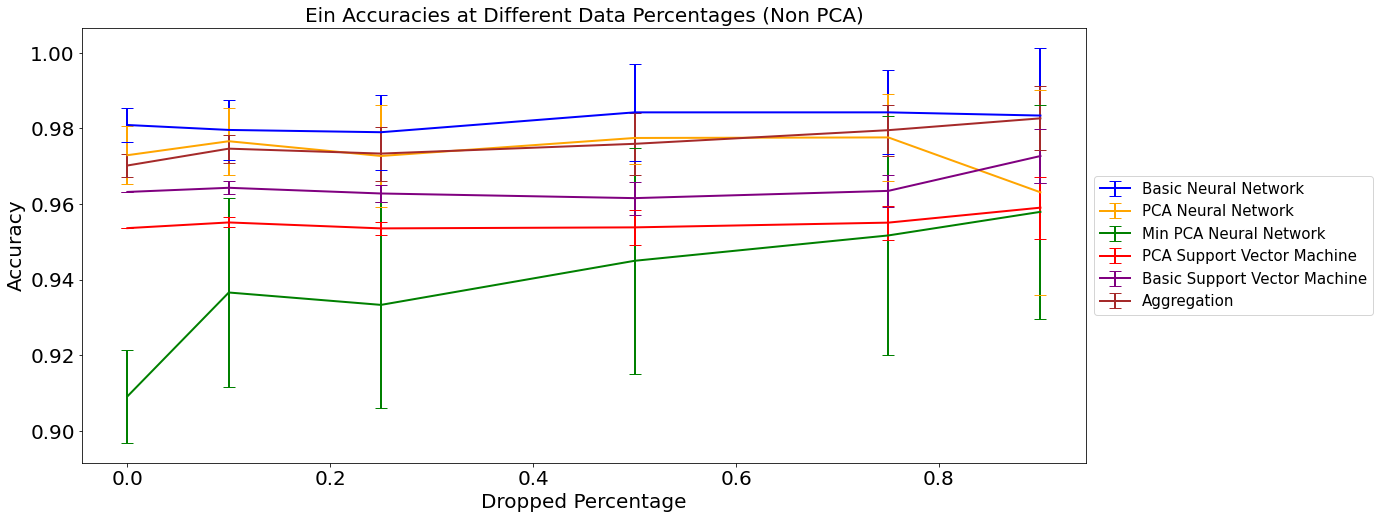

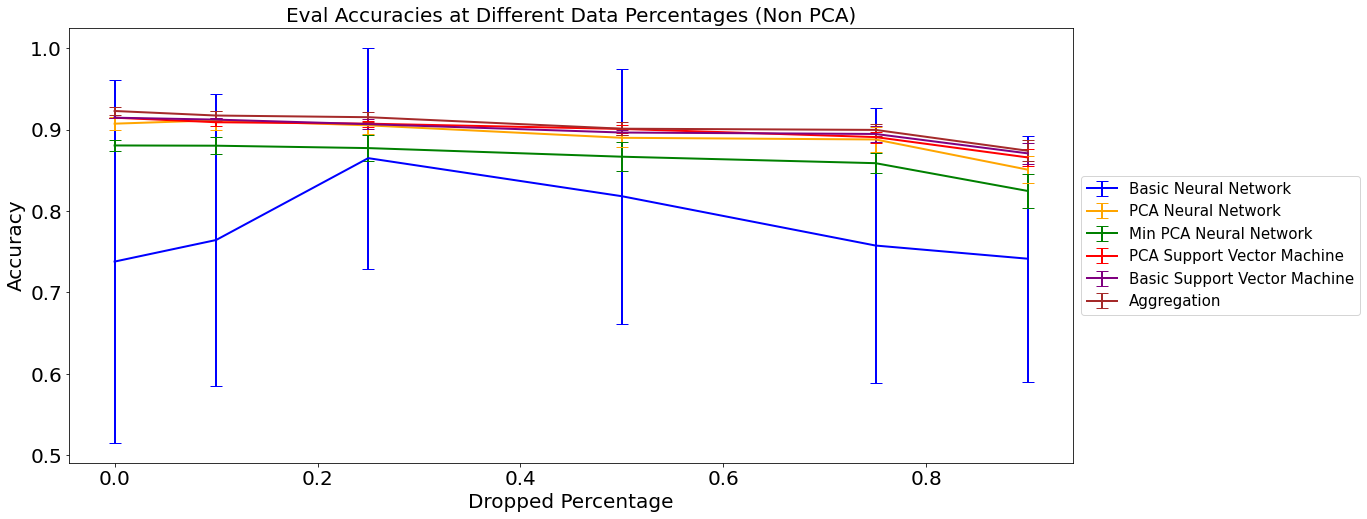

In [47]:
fig, ax = plt.subplots(figsize=(18,8))
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)

# accPlotBNN, valAccPlotBNN, stdAccPlotBNN, stdvalAccPlotBNN = averageValues(accBNN, valAccBNN)
# print("BNN Acc:",accPlotBNN, "\nBNN valAcc:", valAccPlotBNN, "\nBNN Acc std:", stdAccPlotBNN, 
#       "\nBNN Val std:", stdvalAccPlotBNN)

# accPlotPNN, valAccPlotPNN, stdAccPlotPNN, stdvalAccPlotPNN = averageValues(accPNN, valAccPNN)
# print("PNN Acc:",accPlotPNN, "\nPNN valAcc:", valAccPlotPNN, "\nPNN Acc std:", stdAccPlotPNN, 
#       "\nPNN Val std:", stdvalAccPlotPNN)

# accPlotMin, valAccPlotMin, stdAccPlotMin, stdvalAccPlotMin = averageValues(accMin, valAccMin)
# print("Min Acc:",accPlotMin, "\nMin valAcc:", valAccPlotMin, "\nMin Acc std:", stdAccPlotMin, 
#       "\nMin Val std:", stdvalAccPlotMin)

# accPlotPSVM , valAccPlotPSVM, stdAccPlotPSVM, stdvalAccPlotPSVM = averageValues(accPSVM , valAccPSVM )
# print("PSVM Acc:",accPlotPSVM , "\nPSVM valAcc:", valAccPlotPSVM, "\nPSVM Acc std:", stdAccPlotPSVM, 
#       "\nPSVM Val std:", stdvalAccPlotPSVM)

# accPlotBSVM , valAccPlotBSVM, stdAccPlotBSVM, stdvalAccPlotBSVM = averageValues(accBSVM , valAccBSVM )
# print("BSVM Acc:",accPlotBSVM , "\nBSVM valAcc:", valAccPlotBSVM, "\nBSVM Acc std:", stdAccPlotBSVM, 
#       "\nBSVM Val std:", stdvalAccPlotBSVM)

# accPlotAGG, valAccPlotAGG, stdAccPlotAGG, stdvalAccPlotAGG = averageValues(accAGG, valAccAGG)
# print("AGG Acc:",accPlotAGG, "\nAGG valAcc:", valAccPlotAGG, "\nAGG Acc std:", stdAccPlotAGG, 
#       "\nAGG Val std:", stdvalAccPlotAGG)

# ax.plot(dataDropped,accPlotBNN, label = "Basic Neural Network")
# ax.plot(dataDropped,accPlotPNN, label = "PCA Neural Network")
# ax.plot(dataDropped,accPlotMin, label = "Min PCA Neural Network")
# ax.plot(dataDropped,accPlotPSVM, label = "PCA Support Vector Machine")
# ax.plot(dataDropped,accPlotBSVM, label = "Basic Support Vector Machine")
# ax.plot(dataDropped,accPlotAGG, label = "Aggregation")

ax.errorbar(dataDropped,accPlotBNN, stdAccPlotBNN, color = "blue",linewidth=2, capsize=6, label = "Basic Neural Network")
ax.errorbar(dataDropped,accPlotPNN, stdAccPlotPNN,color = "orange", linewidth=2, capsize=6, label = "PCA Neural Network")
ax.errorbar(dataDropped,accPlotMin, stdAccPlotMin, color = "green", linewidth=2, capsize=6, label = "Min PCA Neural Network")
ax.errorbar(dataDropped,accPlotPSVM, stdAccPlotPSVM,  color = "red", linewidth=2, capsize=6, label = "PCA Support Vector Machine")
ax.errorbar(dataDropped,accPlotBSVM, stdAccPlotBSVM, color = "purple", linewidth=2, capsize=6, label = "Basic Support Vector Machine")
ax.errorbar(dataDropped,accPlotAGG, stdAccPlotAGG,  color = "brown",linewidth=2, capsize=6, label = "Aggregation")
#ax.errorbar(xval, yval, xerr = 0.4, yerr = 0.5)

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize = 15)
ax.set_title("Ein Accuracies at Different Data Percentages (Non PCA)", fontsize = 20)
ax.set_xlabel("Dropped Percentage", fontsize = 20)
ax.set_ylabel("Accuracy", fontsize = 20)
ax.set_facecolor("white")



fig, ax = plt.subplots(figsize=(18,8))
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)

ax.errorbar(dataDropped, valAccPlotBNN, stdvalAccPlotBNN,color = "blue",linewidth=2, capsize=6, label = "Basic Neural Network")
ax.errorbar(dataDropped,valAccPlotPNN, stdvalAccPlotPNN, color = "orange",linewidth=2, capsize=6, label = "PCA Neural Network")
ax.errorbar(dataDropped,valAccPlotMin, stdvalAccPlotMin, color = "green",linewidth=2, capsize=6, label = "Min PCA Neural Network")
ax.errorbar(dataDropped,valAccPlotPSVM, stdvalAccPlotPSVM, color = "red",linewidth=2, capsize=6, label = "PCA Support Vector Machine")
ax.errorbar(dataDropped,valAccPlotBSVM, stdvalAccPlotBSVM, color = "purple",linewidth=2, capsize=6, label = "Basic Support Vector Machine")
ax.errorbar(dataDropped,valAccPlotAGG, stdvalAccPlotAGG, color = "brown",linewidth=2, capsize=6, label = "Aggregation")

# ax.plot(dataDropped, valAccPlotBNN, label = "Basic Neural Network")
# ax.plot(dataDropped, valAccPlotPNN, label = "PCA Neural Network")
# ax.plot(dataDropped, valAccPlotMin, label = "Min PCA Neural Network")
# ax.plot(dataDropped, valAccPlotPSVM, label = "PCA Support Vector Machine")
# ax.plot(dataDropped, valAccPlotBSVM, label = "Basic Support Vector Machine")
# ax.plot(dataDropped, valAccPlotAGG, label = "Aggregation")

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize = 15)
ax.set_title("Eval Accuracies at Different Data Percentages (Non PCA)", fontsize = 20)
ax.set_xlabel("Dropped Percentage", fontsize = 20)
ax.set_ylabel("Accuracy", fontsize = 20)
ax.set_facecolor("white")